# Team members

Berkin Öztürk & Berker Uğraş

# Step 1

At first, we imported torch, pandas and matplotlib libraries to load the csv files and align the input & output data.

In [2]:
import torch;
import pandas as pd;
import matplotlib.pyplot as plt


# Step 2

Since we have to align them according to dates in the data_y file, we defined a while loop to match the corresponding dates and drop the rest.

In [3]:
indic = pd.read_csv('data_X.csv')
results=pd.read_csv('data_Y.csv')

measurements=indic.iloc[0:,1:].values
results=results.iloc[0:,1:].values

measurements=torch.from_numpy(measurements)
results=torch.from_numpy(results)

measurements=measurements[4325:len(measurements):120]
newMeasurements=torch.zeros(len(results),len(measurements[0]))


a=0
i=0
while i<len(newMeasurements):#4325,len(measurements),120
    if(a>=len(measurements)):
        break
    newMeasurements[i]=measurements[a]
    a=a+1
    if(a!=0 and a%6==0):
        newMeasurements[i+1]=measurements[a]
        i=i+1
        a=a+6   
       
    i=i+1
newMeasurements.shape
results=torch.reshape(results,(-1,))
results

tensor([392, 393, 400,  ..., 461, 450, 431])

# Step 3 

We wrote a generator function to load batches of data. It receives the data inputs as arguments, outputs, and the batch size and yields a batch of examples at every call, where the batch is a tuple of inputs and outputs in the batch. Since batches shall not always be the same across the epochs, we shuffled the data by using the .randperm function to have random indexes and stored them in the batch_idx list. And by using these indexes, which are in the batch_idx, we provided the randomness.


In [4]:
#Generator Function
def iter_data(inputs,outputs,batch_size):
    n=inputs.shape[0]
    idx=torch.randperm(n)
    for i in range(0,n,batch_size):
        batch_end=min(i+batch_size,n)
        batch_idx=idx[i:batch_end]
        batch=inputs[batch_idx[0:]],outputs[batch_idx[0:]]
        yield batch

In [5]:
batches=iter_data(newMeasurements[:30],results[:30],7)

In [6]:
next(batches)

(tensor([[236.0000, 238.0000, 245.0000, 323.0000, 320.0000, 318.0000, 522.0000,
          501.0000, 524.0000, 343.0000, 371.0000, 344.0000, 264.0000, 263.0000,
          265.0000, 195.7100,   7.9700],
         [229.0000, 234.0000, 230.0000, 315.0000, 344.0000, 323.0000, 515.0000,
          573.0000, 509.0000, 364.0000, 349.0000, 361.0000, 248.0000, 240.0000,
          246.0000, 162.5800,   6.3600],
         [298.0000, 298.0000, 297.0000, 369.0000, 338.0000, 337.0000, 530.0000,
          586.0000, 884.0000, 339.0000, 332.0000, 333.0000, 213.0000, 230.0000,
          214.0000, 165.5800,   7.7100],
         [211.0000, 206.0000, 207.0000, 309.0000, 302.0000, 308.0000, 524.0000,
          497.0000, 498.0000, 395.0000, 376.0000, 365.0000, 251.0000, 237.0000,
          264.0000, 193.8800,   9.1900],
         [183.0000, 211.0000, 210.0000, 311.0000, 309.0000, 305.0000, 502.0000,
          503.0000, 541.0000, 361.0000, 342.0000, 347.0000, 260.0000, 260.0000,
          268.0000, 196.0600,   7.17

# Step 4

We defined the linear model. It takes as arguments the input data and the model parameters (weights and bias) and returns the output predictions.

In [7]:
def Linear_Reg(inputs,weights,bias):
        return inputs.matmul(weights)+bias

# Step 5

In step 5, to test our linear model, we used random weight & bias parameters.

In [8]:
#random w and b parameeter
values=torch.rand(17)
w=values.clone().detach().requires_grad_(True)
b=torch.tensor([0.],requires_grad=True)

y_hat=Linear_Reg(newMeasurements,w,b)
print(y_hat-results)

tensor([2554.0737, 2461.5054, 2473.9521,  ..., 2403.5745, 2486.7502,
        2476.7771], grad_fn=<SubBackward0>)


# Step 6

In this step, we calculated the square error and did back propagation.

In [9]:
#gradients
err=torch.mean((y_hat-results)**2)
err
err.backward()

# Step 7

We defined the our loss function as the average squared error of the predictions – the function taking in the
predictions and true labels and returning the value of the loss.

In [10]:
# define a function loss_func(labels, preds) -> error
# --- YOUR CODE HERE --

def Loss_Function(labels,preds):
    return torch.mean(0.5*(preds-labels)**2)

In [11]:
Loss_Function(y_hat,results)

tensor(3090058., grad_fn=<MeanBackward0>)

# Step 8 

We created our SGD function -minibatch stochastic gradient descent. Since SGD is an operation in the optimization procedure and as such shall not be part of the computational graph - we do not need to update parameter gradients, for this reason we used torch.no_grad function.

In [12]:
#Optimization Algorithm Minibatch Stochastic
def sgd_step(params, learn_rate, batch_size):
    for param in params:
        with torch.no_grad():
            param-=learn_rate/batch_size * param.grad
            param.grad.zero_()
    


In [13]:
print(f'before:{w},{b}')
sgd_step([w,b],0.001,30)
print(f'after:{w},{b}')

before:tensor([0.6339, 0.6012, 0.9160, 0.5382, 0.2155, 0.8245, 0.6229, 0.8499, 0.0625,
        0.0993, 0.7659, 0.8522, 0.0017, 0.9627, 0.2477, 0.6764, 0.6484],
       requires_grad=True),tensor([0.], requires_grad=True)
after:tensor([-40.7684, -40.7413, -40.5195, -57.4819, -57.6550, -57.2005, -82.6713,
        -82.4041, -83.3058, -57.6694, -57.0169, -57.1244, -41.3627, -40.3885,
        -41.1595, -28.2462,  -0.5923], requires_grad=True),tensor([-0.1654], requires_grad=True)


# Step 9

At this step, we defined our training procedure. We also defined number of epochs, batch size and learning rate values as it should be at every training process. We set our hyper parameters (learning rate, batch size , number of epochs) manually according to result of loss values. In the training process, we updated the model parameters by using our optimizer (minibatch stochastic gradient descent). To monitor the training loss evaluation we benefit from matplotlib and printed the loss value after every epoch. 

tensor([ 1.4457, -1.1251,  0.8185,  0.3452,  1.3005, -1.7227,  0.6513,  1.1744,
        -0.0298,  0.4271, -0.8395,  0.1696, -1.1807,  1.1566, -0.2728, -0.3074,
         0.0478], requires_grad=True)
loss 7578.75537109375
loss 7280.001953125
loss 5647.16845703125
loss 6154.19287109375
loss 4534.765625
loss 4082.85009765625
loss 7085.353515625
loss 5151.24462890625
loss 4653.08935546875
loss 4367.94775390625
loss 4921.05322265625
loss 3719.779541015625
loss 8200.4716796875
loss 4082.18310546875
loss 2481.304443359375
loss 4312.50634765625
loss 2846.50341796875
loss 3919.49169921875
loss 2282.142333984375
loss 1982.7052001953125
loss 1930.4478759765625
loss 3125.35546875
loss 1925.7115478515625
loss 2671.35009765625
loss 2053.06884765625
loss 5848.57666015625
loss 3081.61083984375
loss 2719.98291015625
loss 5394.25
loss 2995.067626953125
loss 1591.318359375
loss 1407.288330078125
loss 4690.01171875
loss 3246.86474609375
loss 2206.63427734375
loss 1919.402587890625
loss 775.8829956054688
lo

loss 397.47503662109375
loss 631.4730224609375
loss 397.8879699707031
loss 305.6984558105469
loss 259.0244140625
loss 345.6018371582031
loss 428.478759765625
loss 451.8051452636719
loss 497.575439453125
loss 501.2178039550781
loss 392.7601623535156
loss 483.99456787109375
loss 598.4249877929688
loss 330.0410461425781
loss 387.8362121582031
loss 548.9459228515625
loss 420.23858642578125
loss 606.2246704101562
loss 536.9953002929688
loss 429.40716552734375
loss 308.9372863769531
loss 489.7255859375
loss 352.02532958984375
loss 479.14501953125
loss 295.0059814453125
loss 484.5189514160156
loss 428.7471618652344
loss 363.4444274902344
loss 366.30816650390625
loss 680.0874633789062
loss 474.7491149902344
loss 273.18975830078125
loss 316.2249755859375
loss 234.78182983398438
loss 647.1820678710938
loss 380.2120361328125
loss 579.5480346679688
loss 478.7327880859375
loss 682.2523193359375
loss 407.84698486328125
loss 290.7513732910156
loss 441.5628967285156
loss 802.8681030273438
loss 485.734

loss 357.01513671875
loss 391.74322509765625
loss 306.82537841796875
loss 543.410400390625
loss 348.0943603515625
loss 868.400634765625
loss 311.603515625
loss 328.1185302734375
loss 288.61077880859375
loss 350.6279602050781
loss 501.6229248046875
loss 330.0567626953125
loss 475.1842041015625
loss 406.4109191894531
loss 316.1250915527344
loss 756.8906860351562
loss 320.4937744140625
loss 425.35552978515625
loss 348.95294189453125
loss 389.7572021484375
loss 342.56146240234375
loss 330.9590759277344
loss 352.36724853515625
loss 380.516357421875
loss 388.98504638671875
loss 600.2908935546875
loss 372.12078857421875
loss 321.8591003417969
loss 321.74945068359375
loss 334.359375
loss 730.710693359375
loss 480.5279541015625
loss 422.4017333984375
loss 284.6346740722656
loss 451.3453369140625
loss 384.87200927734375
loss 729.07470703125
loss 408.7728271484375
loss 423.3243408203125
loss 458.825439453125
loss 305.5806884765625
loss 421.7923278808594
loss 417.21661376953125
loss 372.1180419921

loss 494.9483642578125
loss 366.32464599609375
loss 459.0738525390625
loss 337.6313781738281
loss 363.2275390625
loss 551.3720092773438
loss 497.9190368652344
loss 553.4082641601562
loss 323.12615966796875
loss 497.3868408203125
loss 446.4252624511719
loss 362.6329650878906
loss 350.0099792480469
loss 442.7615661621094
loss 279.1993408203125
loss 687.7481079101562
loss 378.2934875488281
loss 524.8873901367188
loss 369.2953796386719
loss 374.23248291015625
loss 278.6727294921875
loss 658.1229248046875
loss 467.3301696777344
loss 598.4109497070312
loss 255.613525390625
loss 243.1964874267578
loss 526.8643188476562
loss 406.4610595703125
loss 504.800537109375
loss 384.687255859375
loss 403.748291015625
loss 295.1748046875
loss 419.291259765625
loss 456.82684326171875
loss 558.7097778320312
loss 380.2127990722656
loss 409.1585693359375
loss 448.1282958984375
loss 561.64306640625
loss 344.5418395996094
loss 473.8985595703125
loss 438.6227722167969
loss 326.906982421875
loss 350.297973632812

loss 347.0264587402344
loss 341.4560241699219
loss 354.5184631347656
loss 439.3745422363281
loss 357.8902587890625
loss 623.09423828125
loss 337.414306640625
loss 387.25347900390625
loss 383.51019287109375
loss 297.2076110839844
loss 297.0413513183594
loss 438.51666259765625
loss 578.4052734375
loss 423.39495849609375
loss 319.8533935546875
loss 291.3834228515625
loss 456.5464782714844
loss 401.3031311035156
loss 426.40386962890625
loss 311.4775390625
loss 236.1425323486328
loss 275.5554504394531
loss 492.6764831542969
loss 337.18670654296875
loss 492.80755615234375
loss 349.95611572265625
loss 297.46563720703125
loss 438.1418151855469
loss 354.025390625
loss 379.6389465332031
loss 362.7607116699219
loss 584.7579956054688
loss 423.33746337890625
loss 324.8386535644531
loss 408.5301208496094
loss 276.087646484375
loss 412.93365478515625
loss 379.0496520996094
loss 434.0029296875
loss 338.8439636230469
loss 418.1705322265625
loss 346.8443908691406
loss 331.2395935058594
loss 274.40109252

loss 316.6721496582031
loss 374.238037109375
loss 432.13916015625
loss 272.4308776855469
loss 354.67498779296875
loss 406.01507568359375
loss 427.6387939453125
loss 361.9469909667969
loss 472.5588684082031
loss 326.45703125
loss 289.4038391113281
loss 572.046142578125
loss 208.7650604248047
loss 303.90911865234375
loss 399.4202880859375
loss 302.3722229003906
loss 403.9847717285156
loss 436.00750732421875
loss 399.3282165527344
loss 356.9268493652344
loss 494.8403625488281
loss 303.871826171875
loss 341.1860656738281
loss 504.48089599609375
loss 494.6145324707031
loss 341.3919677734375
loss 251.042724609375
loss 315.5506286621094
loss 399.81689453125
loss 386.02276611328125
loss 424.1636657714844
loss 294.79248046875
loss 413.41937255859375
loss 314.8946228027344
loss 294.6028137207031
loss 472.398193359375
loss 364.4947509765625
loss 457.65240478515625
loss 185.48269653320312
loss 309.9646911621094
loss 1106.358154296875
loss 381.25152587890625
loss 381.3868103027344
loss 464.28448486

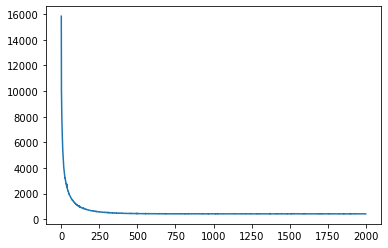

In [14]:
#model training Procedure
num_epochs=2000
w=torch.randn(17,requires_grad=True)
b=torch.randn(1,requires_grad=True)
bs=256 #generally powers of 2
lr=0.0001

losses=[]
print(w)
for epoch in range(num_epochs):
    ll=0
    for i,batch in enumerate(iter_data(newMeasurements,results,bs)):
        x_batch,y_batch=batch[0],batch[1]
        y_hat=Linear_Reg(x_batch,w,b)
        loss=Loss_Function(y_hat,y_batch)
        ll +=loss
        loss.backward()
        sgd_step([w,b],lr,len(x_batch))
    print(f'loss {loss}')
    losses.append(ll.item()/i)

print(w)   
plt.plot(losses[:])


# Step 10

After the training procedure we use the trained parameters for predictions on the whole dataset. We iterated through all the data batches and finally, we calculated the total average loss. 

In [15]:
with torch.no_grad():
    sum=0
    for i,batch in enumerate(iter_data(newMeasurements,results,bs)):
            x_batch,y_batch=batch[0],batch[1]
            y_hat=Linear_Reg(x_batch,w,b)
            loss=Loss_Function(y_hat,y_batch)
            print(loss)
            sum+=loss
print("average loss",sum/(i+1))



tensor(404.0110)
tensor(384.7487)
tensor(390.4334)
tensor(315.4136)
tensor(413.1219)
tensor(367.3969)
tensor(381.2802)
tensor(444.2348)
tensor(443.6051)
tensor(358.7421)
tensor(393.0565)
tensor(370.5641)
tensor(494.2720)
tensor(358.1895)
tensor(474.4608)
tensor(416.6631)
tensor(396.0587)
tensor(402.0932)
tensor(300.5665)
tensor(458.8990)
tensor(359.4384)
tensor(466.9780)
tensor(428.9382)
tensor(468.0628)
tensor(320.5005)
tensor(470.5842)
tensor(480.2803)
tensor(403.0075)
tensor(436.1693)
tensor(387.9509)
tensor(311.2054)
tensor(410.1387)
tensor(487.2819)
tensor(477.9733)
average loss tensor(408.1271)


# Comments

We discovered that how important is to choose the learning rate, batch size, and the number of epochs for getting a good value of the loss. In the end, we decided that the best hyperparameter values to obtain the best possible loss values are; learning rate: 0.0001, batch size: 256, and the number of epochs: 2000. And also, we understand that how we can train a model.